In [1]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from numpy.fft import fftshift, fft2
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter, map_coordinates
from scipy.misc import imresize
from scipy.ndimage.filters import convolve as conv2
from scipy.ndimage.filters import convolve1d as conv1

from utils import rgb2gray, imnoise, add_gaussian_noise, gaussian2, affinefit

In [2]:
from skimage.transform import pyramid_gaussian
from skimage.transform import pyramid_laplacian

In [3]:
## Implement missing functions: 
## generateLaplacianPyramid and reconstLaplacianPyramid
 
## Notice that in this implementation the first level of a Gaussian pyramid 
## is the original image, and the last level of a Laplacian pyramid is the
## same as the corresponding level in the Gaussian pyramid.

man = imread('assets/man_color.jpg') / 255.
man = resize(man, (int(man.shape[0] / 2), int(man.shape[1] / 2)))

wolf = imread('assets/wolf_color.jpg') / 255.
wolf = resize(wolf, (wolf.shape[0] / 2, wolf.shape[1] / 2))

# the pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461], [652, 457], [554, 823]])
wolf_eyes_chin=np.array([[851, 919], [1159, 947], [975, 1451]])
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size, 1)).T

wolft = np.zeros(man.shape)

for ch in range(3):
    wolft[:,:,ch] = map_coordinates(wolf[:,:,ch], (pt[1, :].reshape(man.shape[:2]),
                               pt[0, :].reshape(man.shape[:2])))


## Manually defined binary mask with an elliptical shape is constructed
## as well as its complement
x0=553.
y0=680.
a=160. 
b=190.
pixmask = (((xv-x0) / a) ** 2 + ((yv-y0) / b) ** 2) < 1

maskb = np.zeros(man.shape)
maskbw = np.zeros(man.shape[:2])
maskbw[pixmask] = 1.0
for c in range(3):
     maskb[:, :, c] = maskbw
maska = 1.0 - maskb

imga = resize(man, (1024,1024))
imgb = resize(wolft, (1024, 1024))
maska = resize(maska, (1024, 1024))
maskb = resize(maskb, (1024, 1024))            

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
def reconstLaplacianPyramid(lpyramid):
    image = lpyramid[0][:]
    shape = image.shape[0:2]    
    filter_kernel = 1/16 * np.array([1.0, 4.0, 6.0, 4.0, 1.0])

    for i in range(1, len(lpyramid)):
        current_image = lpyramid[i]
        resized_image = resize(current_image, shape, mode='reflect')

        c1 = conv1(resized_image, filter_kernel, axis=0)
        c2 = conv1(c1, filter_kernel, axis=1)
        image += c2    
    
    return image

In [5]:
level = 8
 
## Make Laplacian image pyramids with 8 levels.
## Output is cell array (i.e. lpimga{i} is the Laplacian image at level i).
## The image at the final level is the base level image from the
## corresponding Gaussian pyramid.
## In the version below the second input is either 'laplacian' or 'gaussian',
## and it defines whether to output Laplacian or Gaussian pyramid.
## After you have implemented the functions above you can uncomment the lines below
## to finally plot the lacking figures ('Pyramid Blending' and 'Difference')


lpimga = list(pyramid_laplacian(image=imga, max_layer=level))
lpimgb = list(pyramid_laplacian(image=imgb, max_layer=level))

## Just check that your pyramid and reconstruction both work
ima = reconstLaplacianPyramid(lpimga)
max_reconstruction_error = np.amax(np.abs(imga.flatten() - ima.flatten()))
print("Reconstruction error: {}".format(max_reconstruction_error))

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Reconstruction error: 0.8653805532720132


In [6]:
## Make Gaussian image pyramids of the mask images, maska and maskb
gpmaska = list(pyramid_gaussian(image=maska, max_layer=level))
gpmaskb = list(pyramid_gaussian(image=maskb, max_layer=level))

# Make smooth masks in a simple manner for comparison
smaska = gaussian_filter(maska, 20)
smaskb = gaussian_filter(maskb, 20)

## In practice, you can also use the Gaussian pyramids of smoothed masks. 
## In this case, the blendings (simple & pyramid) will appear more similar.
gpsmaska = list(pyramid_gaussian(image=smaska, max_layer=level))
gpsmaskb = list(pyramid_gaussian(image=smaskb, max_layer=level))

limgo = {} # the blended pyramid
for p in range(level):
#    # Blend the Laplacian images at each level
#    # (You can use either one of the two rows below.)
#    limgo[p] = (lpimga[p]*gpmaska[p] + lpimgb[p]*gpmaskb[p])/(gpmaska[p]+gpmaskb[p])
   limgo[p] = (lpimga[p]*gpsmaska[p] + lpimgb[p]*gpsmaskb[p])/(gpsmaska[p]+gpsmaskb[p])

## Reconstruct the blended image from its Laplacian pyramid
imgo = reconstLaplacianPyramid(limgo);

## Simple blending with smooth masks
imgo1 = smaska*imga + smaskb*imgb

/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/adam/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


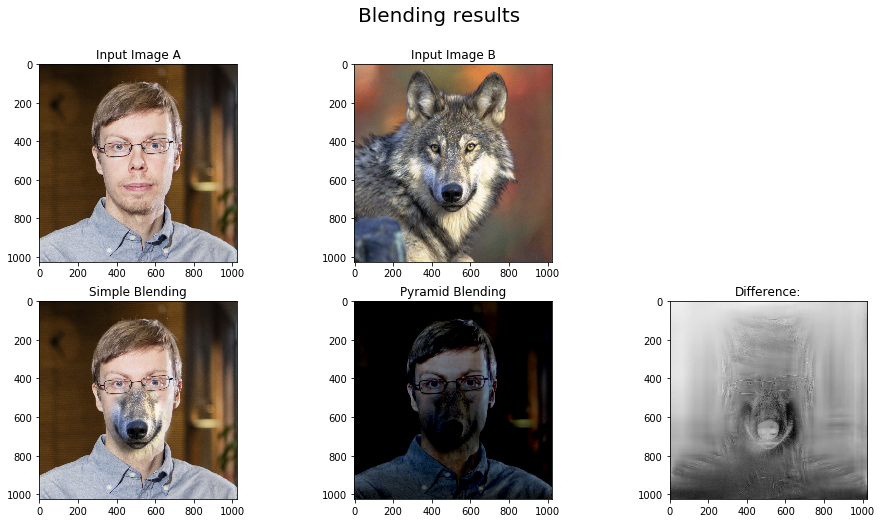

In [7]:
## Display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
plt.suptitle("Blending results", fontsize=20)
ax = axes.ravel()
ax[0].imshow(imga, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(imgb, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].set_visible(False)
ax[3].imshow(imgo1, cmap='gray')
ax[3].set_title("Simple Blending")
ax[4].imshow(imgo, cmap='gray')
ax[4].set_title("Pyramid Blending")
ax[5].imshow(np.amax(imgo-imgo1, axis=2), cmap='gray')
ax[5].set_title("Difference:")
plt.show()